This notebook tests a number of methods for MLD_grid.py\
produce mld values in half-deg boxes within a large horizontal area, avging over 1 month of time

In [1]:
# dependencies
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import zarr
import dask

from fastjmd95 import jmd95numba 
from xhistogram.xarray import histogram

In [2]:
# first define a helper function to rotate plots for N-S/vertical alignment
def rotate_axes_90_clockwise(ax):
    """
    Robustly rotate a Matplotlib Axes 90 degrees clockwise by:
      - rendering the figure to an RGBA buffer,
      - cropping the pixels belonging to the given Axes,
      - rotating the image 90 deg clockwise,
      - placing the rotated image back into the figure at the same axes position,
      - removing the original Axes.

    Notes:
    - This rasterizes the axis contents (the result is an image, not vector art).
    - Colorbars or other axes that live outside the target `ax` are left alone.
    - Works reliably for full grids or arbitrary subsets.
    """
    fig = ax.figure

    # Force draw so renderer & sizes are correct
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Get pixel bbox of the axes (in display coordinates) via renderer-aware call
    bbox = ax.get_window_extent(renderer=renderer)  # Bbox in display (pixel) coords

    # Grab the full figure RGBA buffer (H x W x 4)
    buf = np.asarray(renderer.buffer_rgba())  # returns an (H,W,4) uint8 array

    H, W = buf.shape[0], buf.shape[1]

    # Convert bbox to integer pixel coords and crop.
    # Note: Bbox y coords are in display coordinates with origin at lower-left.
    x0, x1 = int(np.floor(bbox.x0)), int(np.ceil(bbox.x1))
    y0, y1 = int(np.floor(bbox.y0)), int(np.ceil(bbox.y1))

    # Convert to numpy row indices (origin at top-left)
    row0 = max(0, H - y1)
    row1 = min(H, H - y0)
    col0 = max(0, x0)
    col1 = min(W, x1)

    if row1 <= row0 or col1 <= col0:
        raise RuntimeError("Calculated zero-size axes crop — renderer/coords inconsistent.")

    axes_img = buf[row0:row1, col0:col1, :].copy()  # copy to be safe

    # Rotate 90 degrees clockwise. np.rot90 rotates counterclockwise, so use k=-1 (or k=3).
    rotated = np.rot90(axes_img, k=-1)

    # Create a new axes in the same figure position (figure coords) and show the rotated image.
    # We must compute the original axes position in figure coordinates:
    fig_x0, fig_y0, fig_w, fig_h = ax.get_position().bounds

    # Add overlaid axes and show the rotated image
    new_ax = fig.add_axes([fig_x0, fig_y0, fig_w, fig_h], anchor='C')  # same place
    new_ax.imshow(rotated, origin='upper', aspect='auto')
    new_ax.set_axis_off()

    # Remove the original axes (so only rotated image remains)
    fig.delaxes(ax)

    # Force redraw
    fig.canvas.draw()
    return new_ax

# function to get i,j indices from target lat/lon vals
def i_j_from_lat_lon(coord_centers, num_boxes, coord_min):
    i = []
    j = []
    for box in range(int(num_boxes)):
        # get lat/lon in increments
        target = coord_min + 0.1 * box

        # get index closest to lat/lon targets
        dist = np.abs(coord_centers - target)
        flat_idx = np.nanargmin(dist)
        i_, j_ = np.unravel_index(flat_idx, coord_centers.shape)
        
        i.append(int(i_)), j.append(int(j_))
    return i, j

# function to get lat/lon vals from i, j indices
def lat_lon_from_i_j(LLC):
    lats = []
    lons = []
    lats.append(LLC['YC'][0,:].values)
    lons.append(LLC['XC'][:,0].values)

    return lats, lons

In [3]:
data_dir = '/orcd/data/abodner/002/cody/MLD_per_pixel'
data = 'MLD_test_face7_(432,9192)_((2000, 2540))'
MLD_per_pixel = xr.open_zarr(f'{data_dir}/{data}.zarr',consolidated=False)
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

In [ ]:
sub = llc.isel(time=slice(2640,3384))

In [40]:
sub.time.values

array(['2012-01-01T00:00:00.000000000', '2012-01-01T01:00:00.000000000',
       '2012-01-01T02:00:00.000000000', '2012-01-01T03:00:00.000000000',
       '2012-01-01T04:00:00.000000000', '2012-01-01T05:00:00.000000000',
       '2012-01-01T06:00:00.000000000', '2012-01-01T07:00:00.000000000',
       '2012-01-01T08:00:00.000000000', '2012-01-01T09:00:00.000000000',
       '2012-01-01T10:00:00.000000000', '2012-01-01T11:00:00.000000000',
       '2012-01-01T12:00:00.000000000', '2012-01-01T13:00:00.000000000',
       '2012-01-01T14:00:00.000000000', '2012-01-01T15:00:00.000000000',
       '2012-01-01T16:00:00.000000000', '2012-01-01T17:00:00.000000000',
       '2012-01-01T18:00:00.000000000', '2012-01-01T19:00:00.000000000',
       '2012-01-01T20:00:00.000000000', '2012-01-01T21:00:00.000000000',
       '2012-01-01T22:00:00.000000000', '2012-01-01T23:00:00.000000000',
       '2012-01-02T00:00:00.000000000', '2012-01-02T01:00:00.000000000',
       '2012-01-02T02:00:00.000000000', '2012-01-02

In [20]:
t1 = MLD_per_pixel.isel(time=0)

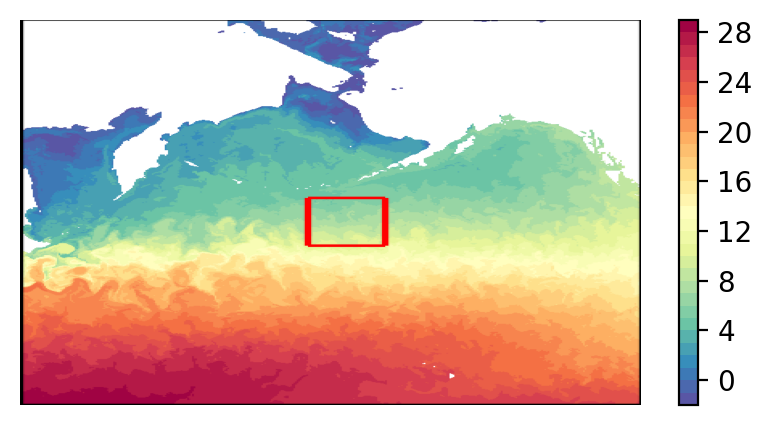

In [21]:
# extract box i,j extents
i_0 = t1.i.values.min()
i_1 = t1.i.values.max()
j_0 = t1.j.values.min()
j_1 = t1.j.values.max()

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=7, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)

plt.show()

Text(0, 0.5, 'Latitude')

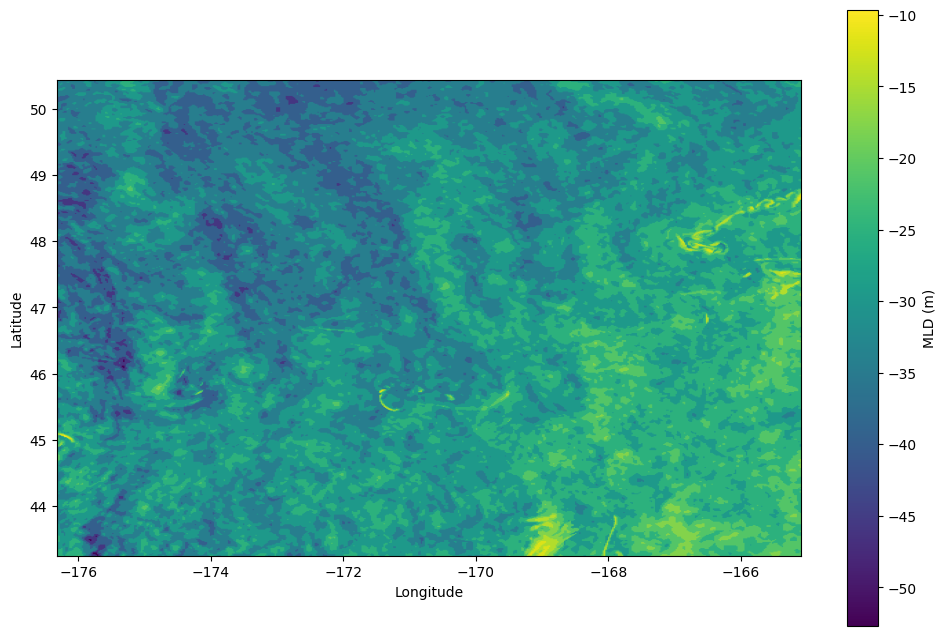

In [13]:
fig, ax = plt.subplots(figsize=(12,8))

contours = ax.imshow(
    t1["MLD_pixels"],
    extent=[
        float(t1.XC.min()), float(t1.XC.max()),
        float(t1.YC.min()), float(t1.YC.max()),
    ],
    origin="lower"
)

plt.colorbar(contours, ax=ax, label="MLD (m)")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


In [2]:
# set location
face = 7
# set temporal params
t_0 = 432
t_1 = t_0 + (365*24) 

# horizontal subsets
h_0 = 2000
h_1 = h_0 + 540

In [3]:
LLC_face = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False, chunks={"time": 96,"k": -1,"i": 384,"j": 384,},)

# select temporal extent, select face
LLC_sub = LLC_face.isel(time=slice(t_0,t_1), face = face, i = slice(h_0,h_1), j = slice(h_0,h_1))[['Theta','Salt','Z','XC','YC']]


/tmp/ipykernel_271739/414814915.py:1: UserWarning: The specified chunks separate the stored chunks along dimension "j" starting at index 384. This could degrade performance. Instead, consider rechunking after loading.
  LLC_face = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False, chunks={"time": 96,"k": -1,"i": 384,"j": 384,},)
/tmp/ipykernel_271739/414814915.py:1: UserWarning: The specified chunks separate the stored chunks along dimension "i" starting at index 384. This could degrade performance. Instead, consider rechunking after loading.
  LLC_face = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False, chunks={"time": 96,"k": -1,"i": 384,"j": 384,},)


In [4]:
LLC_sub

<xarray.Dataset> Size: 1TB
Dimensions:  (time: 8760, k: 51, j: 540, i: 540)
Coordinates:
  * i        (i) int16 1kB 2000 2001 2002 2003 2004 ... 2535 2536 2537 2538 2539
  * j        (j) int16 1kB 2000 2001 2002 2003 2004 ... 2535 2536 2537 2538 2539
  * time     (time) datetime64[ns] 70kB 2011-10-01 ... 2012-09-29T23:00:00
    face     int16 2B 7
  * k        (k) int16 102B 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
Data variables:
    Theta    (time, k, j, i) float32 521GB dask.array<chunksize=(48, 51, 304, 304), meta=np.ndarray>
    Salt     (time, k, j, i) float32 521GB dask.array<chunksize=(48, 51, 304, 304), meta=np.ndarray>
    Z        (k) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    XC       (j, i) float32 1MB dask.array<chunksize=(304, 304), meta=np.ndarray>
    YC       (j, i) float32 1MB dask.array<chunksize=(304, 304), meta=np.ndarray>

In [25]:
# open llc
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)
llc_sub = llc.isel(time=slice(0,24), i = slice(2000,2024), j = slice(2000,2024), face = 7)

In [26]:
llc_sub = llc_sub[['rA','Theta','Salt','XC','YC','Z']]

In [27]:
# calculate mld per column
rho0 = 1025 #ref den in kg/m^3
kref = 6 # 10m
dens_thres = 0.03 
def calc_MLD_col(theta, salt, z, rho0=rho0, kref=kref, dens_thres=dens_thres):
    # theta, salt, z are (k,)

    rho = jmd95numba.rho(salt, theta, 0) - rho0
    drho = rho - rho[kref]

    mask = drho <= dens_thres

    if not np.any(mask):
        return np.nan
    return np.min(z[mask])

In [28]:
    MLD_pixels = xr.apply_ufunc( # use ufunc along single columns to manage memory
        calc_MLD_col,
        llc_sub.Theta,
        llc_sub.Salt,
        llc_sub.Z,
        input_core_dims=[["k"], ["k"], ["k"]],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[np.float32],)

In [32]:
MLD_pixels.isel(i=10,j=10).values

array([-21.125, -21.125, -21.125, -24.99 , -24.99 , -24.99 , -21.125,
       -21.125, -21.125, -21.125, -21.125, -21.125, -21.125, -21.125,
       -21.125, -24.99 , -24.99 , -24.99 , -24.99 , -24.99 , -21.125,
       -21.125, -21.125, -21.125], dtype=float32)

In [33]:
rho0 = 1025 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0 = jmd95numba.rho(llc_sub.Salt, llc_sub.Theta,0) - rho0

# sigma0 at 10m depth for reference, no broadcasting
sigma0_10m = sigma0.isel(k=6)
delta_sigma = sigma0 - sigma0_10m

MLD_pixels_old = llc_sub.Z.broadcast_like(sigma0).where(delta_sigma<=0.03).min(dim="k",skipna=True)

In [35]:
MLD_pixels_old.isel(i=10,j=10).values

array([-21.125, -21.125, -21.125, -24.99 , -24.99 , -24.99 , -21.125,
       -21.125, -21.125, -21.125, -21.125, -21.125, -21.125, -21.125,
       -21.125, -24.99 , -24.99 , -24.99 , -24.99 , -24.99 , -21.125,
       -21.125, -21.125, -21.125], dtype=float32)

In [3]:
data_dir = '/orcd/data/abodner/002/cody/MLD_per_pixel'
data = 'MLD_face7_(432,9192)'
MLD_per_pixel = xr.open_zarr(f'{data_dir}/{data}.zarr',consolidated=False)

In [11]:
MLD_per_pixel.MLD_pixels.isel(i = 100, j = 100, time = 10).values

array(nan, dtype=float32)

In [3]:
# open llc
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)


In [4]:
# select temporal extent, chunk: k should be full-column per chunk for .min(dim="k
t_0 = 432
t_1 = t_0 + (365*24) 
# horizontal subsets
h_0 = 2000
h_1 = h_0 + 540

llc_box = llc.isel(time=slice(t_0,t_1),i=slice(h_0, h_1), j = slice(h_0, h_1))#.chunk({'time': -1, 'k': -1, 'i': 96, 'j': 96})

In [5]:
llc_box = llc_box[['Theta','Salt','Z','XC','YC']]

In [6]:
rho0 = 1025 #ref den in kg/m^3
kref = 6 # 10m
dens_thres = 0.03 
def calc_MLD_col(theta, salt, z, rho0=rho0, kref=kref, dens_thres=dens_thres):
    # theta, salt, z are (k,)

    rho = jmd95numba.rho(salt, theta, 0) - rho0
    drho = rho - rho[kref]

    mask = drho <= dens_thres

    if not np.any(mask):
        return np.nan
    return np.min(z[mask])

In [7]:
MLD_pixels = xr.apply_ufunc( # use ufunc along single columns to manage memory
        calc_MLD_col,
        llc_box.Theta,
        llc_box.Salt,
        llc_box.Z,
        input_core_dims=[["k"], ["k"], ["k"]],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[np.float32],)

In [8]:
MLD_pixels

<xarray.DataArray (time: 8760, face: 13, j: 540, i: 540)> Size: 133GB
dask.array<transpose, shape=(8760, 13, 540, 540), dtype=float32, chunksize=(1, 1, 380, 380), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int16 1kB 2000 2001 2002 2003 2004 ... 2535 2536 2537 2538 2539
  * j        (j) int16 1kB 2000 2001 2002 2003 2004 ... 2535 2536 2537 2538 2539
  * time     (time) datetime64[ns] 70kB 2011-10-01 ... 2012-09-29T23:00:00
  * face     (face) int16 26B 0 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
# extract box i,j extents
i_0 = llc_box.i.values.min()
i_1 = llc_box.i.values.max()
j_0 = llc_box.j.values.min()
j_1 = llc_box.j.values.max()

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=7, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)

plt.show()

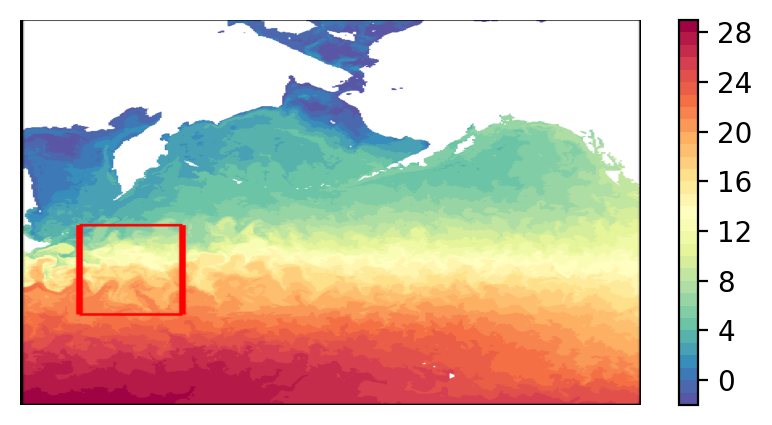

In [10]:
# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=7, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)

plt.show()

In [8]:
# select dims
llc_box = llc_box[['Salt','Theta','XC','YC','Z','rA']]
area = llc_box.rA

In [9]:
# code adapted from https://github.com/abodner/submeso_param_net/blob/main/scripts/preprocess_llc4320/preprocess.py
# reference density 
rho0 = 1025 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0 = jmd95numba.rho(llc_box.Salt, llc_box.Theta,0) - rho0

# sigma0 at 10m depth for reference, no broadcasting
sigma0_10m = sigma0.isel(k=6)
delta_sigma = sigma0 - sigma0_10m

MLD_pixels = llc_box.Z.broadcast_like(sigma0).where(delta_sigma<=0.03).min(dim="k",skipna=True)

# take temporal averages 
time_window = 24 * 30 # month
MLD_pixels = MLD_pixels.coarsen(time=time_window, boundary="trim").mean()

In [13]:
vals = MLD_tiles.values

In [14]:
vals

array([[-25.988535, -26.357176],
       [-26.679358, -25.988234]], dtype=float32)

In [1]:
path = '/orcd/data/abodner/002/cody/MLD_per_pixel/MLD_face7_(432,9192).zarr'
MLD_pixel_test = xr.open_zarr(path)

NameError: name 'xr' is not defined

In [58]:
MLD_pixel_test = MLD_pixel_test.coarsen(time=15*24, boundary="trim").mean()

In [ ]:
MLD_pixel_test

<xarray.Dataset> Size: 65kB
Dimensions:     (time: 2, j: 48, i: 67)
Coordinates:
    face        int16 2B 7
  * i           (i) int16 134B 2798 2799 2800 2801 2802 ... 2861 2862 2863 2864
  * j           (j) int16 96B 744 745 746 747 748 749 ... 787 788 789 790 791
  * time        (time) datetime64[ns] 16B 2011-09-20T11:30:00 2011-10-05T11:3...
Data variables:
    MLD_pixels  (time, j, i) float32 26kB dask.array<chunksize=(1, 48, 67), meta=np.ndarray>
    XC          (j, i) float32 13kB dask.array<chunksize=(48, 67), meta=np.ndarray>
    YC          (j, i) float32 13kB dask.array<chunksize=(48, 67), meta=np.ndarray>
    rA          (j, i) float32 13kB dask.array<chunksize=(48, 67), meta=np.ndarray>

In [63]:
# break into half-deg tiles, weight by surface area
dlat = 0.5
dlon = 0.5
YC = MLD_pixel_test.YC
XC = MLD_pixel_test.XC
area = MLD_pixel_test.rA

lat_edges = np.arange(YC.values.min(), YC.values.max() + dlat, dlat)
lon_edges = np.arange(XC.values.min(), XC.values.max() + dlon, dlon)

num = histogram(
    YC,
    XC,
    bins=[lat_edges, lon_edges],
    weights=MLD_pixel_test['MLD_pixels'] * area,
    dim=("j", "i"))

den = histogram(
    YC,
    XC,
    bins=[lat_edges, lon_edges],
    weights=area,
    dim=("j", "i"))

MLD_tiles = num / den

In [65]:
MLD_tiles

<xarray.DataArray 'histogram_YC_XC' (time: 2, YC_bin: 2, XC_bin: 2)> Size: 32B
dask.array<truediv, shape=(2, 2, 2), dtype=float32, chunksize=(1, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * YC_bin   (YC_bin) float64 16B 38.76 39.26
  * XC_bin   (XC_bin) float64 16B 157.8 158.3
Dimensions without coordinates: time

In [67]:
MLD_tiles.time.values

array([0, 1])

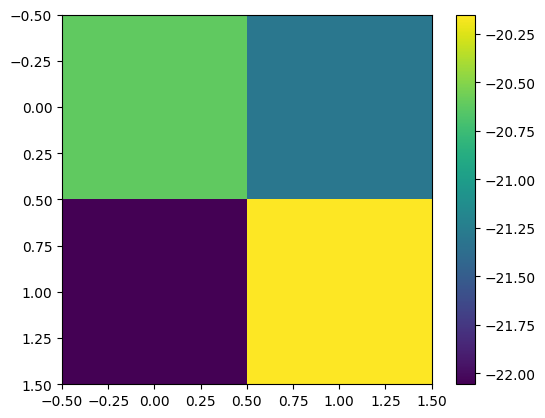

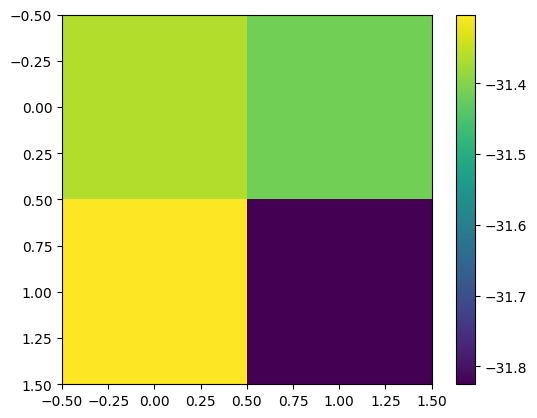

In [73]:
for t in MLD_tiles.time.values:
    plt.imshow(MLD_tiles.isel(time=t))
    plt.colorbar()
    plt.show()

In [10]:
# function to select i-j slices per box by lat/lon boxes
def i_j_slices(LLC, spacing):
    i_start, i_end = [], []
    j_start, j_end = [], []

    XC, YC = LLC['XC'].values, LLC['YC'].values

    # determine lat/lon min/max
    lon_min, lon_max = np.nanmin(XC), np.nanmax(XC)
    lat_min, lat_max = np.nanmin(YC), np.nanmax(YC)

    # number of boxes along lat/lon
    num_boxes_lon = int(np.ceil((lon_max - lon_min) / spacing))
    num_boxes_lat = int(np.ceil((lat_max - lat_min) / spacing))

    # loop over boxes in lat/lon
    for b_lon in range(num_boxes_lon):
        for b_lat in range(num_boxes_lat):
            # start/end lat/lon for this box
            lon_start = lon_min + b_lon * spacing
            lon_end   = lon_start + spacing
            lat_start = lat_min + b_lat * spacing
            lat_end   = lat_start + spacing

            # compute the distance to box corners
            dist_start = np.sqrt((XC - lon_start)**2 + (YC - lat_start)**2)
            dist_end   = np.sqrt((XC - lon_end)**2   + (YC - lat_end)**2)

            # nearest pixel indices
            j_s, i_s = np.unravel_index(np.nanargmin(dist_start), XC.shape)
            j_e, i_e = np.unravel_index(np.nanargmin(dist_end),   XC.shape)

            # sort to ensure proper i/j order
            i0, i1 = sorted([i_s, i_e])
            j0, j1 = sorted([j_s, j_e])

            i_start.append(i0)
            i_end.append(i1)
            j_start.append(j0)
            j_end.append(j1)

    return i_start[::-1], i_end[::-1], j_start, j_end, num_boxes_lon * num_boxes_lat


def iterate_boxes(LLC, resolution_deg):

    i_start, i_end, j_start, j_end, num_boxes = i_j_slices(LLC, resolution_deg)

    box_id = 0
    for i0, i1 in zip(i_start, i_end):
        for j0, j1 in zip(j_start, j_end):
            # only yield boxes with valid size
            if (i1 - i0) > 0 and (j1 - j0) > 0:
                yield box_id, (i0, i1, j0, j1)
                box_id += 1
                
# function to build a box index
def build_sub_index(LLC, resolution_deg,type):
    box = xr.full_like(LLC["XC"], fill_value=-1).astype(int)
    box = box.rename([type])

    for box_id, (i0, i1, j0, j1) in iterate_boxes(LLC, resolution_deg):
        box[j0:j1, i0:i1] = box_id
    return box

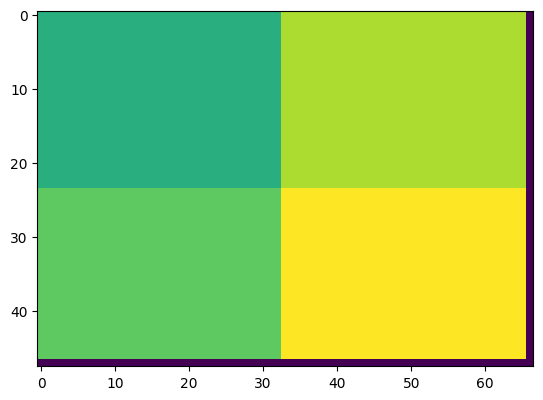

In [11]:
# select dims
llc_box = llc_box[['Salt','Theta','XC','YC','Z','rA']]

# break into half-deg tiles:
# build tile index
tile_width = 0.5
tile_index = build_sub_index(llc_box, tile_width,"tile").compute()
llc_tiles = llc_box.assign_coords(tile=tile_index)
# mask invalid pixels (the purple edges in the fig below)
llc_tiles = llc_tiles.where(llc_tiles.tile >= 0)
plt.imshow(tile_index)

In [21]:
llc_tiles.tile

<xarray.DataArray 'tile' (j: 48, i: 67)> Size: 26kB
array([[ 9,  9,  9, ..., 13, 13, -1],
       [ 9,  9,  9, ..., 13, 13, -1],
       [ 9,  9,  9, ..., 13, 13, -1],
       ...,
       [11, 11, 11, ..., 15, 15, -1],
       [11, 11, 11, ..., 15, 15, -1],
       [-1, -1, -1, ..., -1, -1, -1]], shape=(48, 67))
Coordinates:
  * i        (i) int16 134B 2798 2799 2800 2801 2802 ... 2861 2862 2863 2864
  * j        (j) int16 96B 744 745 746 747 748 749 ... 786 787 788 789 790 791
    face     int16 2B 7
    tile     (j, i) int64 26kB 9 9 9 9 9 9 9 9 9 ... -1 -1 -1 -1 -1 -1 -1 -1 -1
Attributes:
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [12]:
# code adapted from https://github.com/abodner/submeso_param_net/blob/main/scripts/preprocess_llc4320/preprocess.py
# reference density 
rho0 = 1025 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0 = jmd95numba.rho(llc_tiles.Salt, llc_tiles.Theta,0) - rho0

# sigma0 at 10m depth for reference, no broadcasting
sigma0_10m = sigma0.isel(k=6)
delta_sigma = sigma0 - sigma0_10m

MLD_pixels = llc_tiles.Z.broadcast_like(sigma0).where(delta_sigma<=0.03).min(dim="k",skipna=True)
llc_tiles['MLD'] = MLD_pixels

In [72]:
llc_tiles.XC.values

array([[157.51042, 157.51042, 157.51042, ..., 157.51042, 157.51042,
              nan],
       [157.53125, 157.53125, 157.53125, ..., 157.53125, 157.53125,
              nan],
       [157.55208, 157.55208, 157.55208, ..., 157.55208, 157.55208,
              nan],
       ...,
       [158.44792, 158.44792, 158.44792, ..., 158.44792, 158.44792,
              nan],
       [158.46875, 158.46875, 158.46875, ..., 158.46875, 158.46875,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], shape=(48, 67), dtype=float32)

In [13]:
# divide into tiles, weight by surface areas
area = llc_tiles['rA']

MLD_tile = (
    (llc_tiles.MLD * area)
    .groupby("tile")
    .sum()
    / area.groupby("tile").sum())

# take monthly means
MLD_tile_month = MLD_tile.coarsen(time=30*24, boundary="trim").mean()

In [ ]:
MLD_map = MLD_tile_month.isel(time=0).sel(tile=llc_tiles.tile, drop=False)

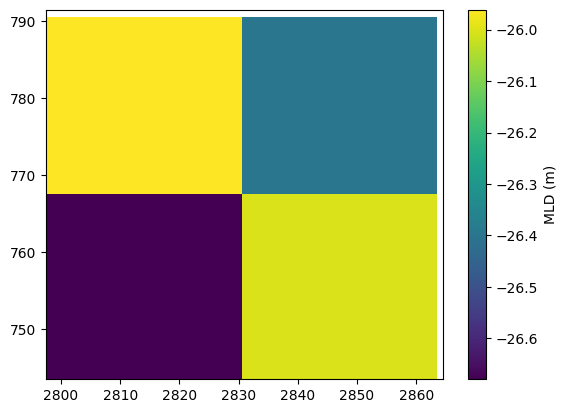

In [25]:
plt.pcolormesh(
    MLD_map.i,
    MLD_map.j,
    MLD_map,
    shading="nearest",
    cmap = 'magma'
)
plt.colorbar(label="MLD (m)")

In [54]:
loc = 'Kuroshio'
lat_center = 39
lon_center = 158
degree_extent = 1.0

slurm_job_name = 'test'

# ------------ 1 deg Agulhas Current centered @ 43°S, 14°E
# loc = 'Agulhas'
# lat_center = -43
# lon_center = 14
# degree_extent = 1.0

# ------------ 1 deg Gulf Stream centered @ 43°S, 14°E
# loc = 'Gulf'
# lat_center = 39
# lon_center = -66
# degree_extent = 1.0

# set temporal extent
t_0 = 0
t_1 = 24 * 1

# exp name
exp_name = str(slurm_job_name) + f'_{loc}' + f'_{degree_extent}deg'

"""
3. open and subset LLC4320
"""

# open LLC4320
LLC_full = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

# select [i,j] spatial box, face, temporal subset
boxes = llc_latlon_box_indices(
LLC_full,
lat_center=lat_center,
lon_center=lon_center,
degree_extent=degree_extent)

subs = []
for face, (j0, j1, i0, i1) in boxes.items():
    subs.append(
        LLC_full.isel(face=face, j=slice(j0, j1), i=slice(i0, i1))
    )

LLC_sub = xr.concat(subs, dim="face")

# select temporal extent, chunk
LLC_sub = LLC_sub.isel(time=slice(t_0,t_1)).chunk({'time': -1, 'i': 96, 'j': 96})

"""
4. Follow code from https://github.com/abodner/submeso_param_net/blob/main/scripts/preprocess_llc4320/preprocess.py
    to calculate the MLD
"""
# reference density 
rho0 = 1025 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0 = jmd95numba.rho(LLC_sub.Salt, LLC_sub.Theta,0) - rho0

# sigma0 at 10m depth for reference
sigma0_10m = sigma0.isel(k=6).broadcast_like(sigma0)
delta_sigma = sigma0 - sigma0_10m

MLD_pixels = LLC_sub.Z.broadcast_like(sigma0).where(delta_sigma<=0.03).min(dim="k",skipna=True)

# average MLD over the box
MLD = MLD_pixels.mean(dim=['i','j','face'])

In [55]:
MLD

<xarray.DataArray 'Z' (time: 24)> Size: 96B
dask.array<mean_agg-aggregate, shape=(24,), dtype=float32, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 192B 2011-09-13 ... 2011-09-13T23:00:00

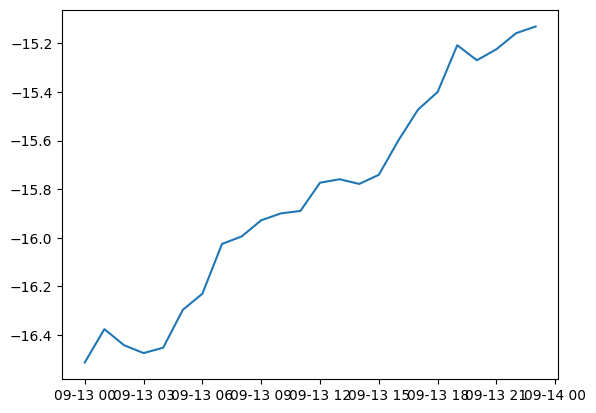

In [56]:
plt.plot(MLD.time, MLD.values)